https://www.kaggle.com/paultimothymooney/blood-cells

Redes Neuronales Convolucionales

#Librerias

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, InputLayer, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.applications.densenet import DenseNet169
from sklearn.metrics import accuracy_score, confusion_matrix

#Importando los datasets

**ImageDataGenerator** es un clase para analizar un directorio (carpeta), para recorrerlo y transformar las imagenes como matrices de 2 dimensiones donde cada elemento es un vector de 3 elementos (RGB).

Los vectores RGB tienen 3 elementos, cada uno con un valor entre 0 y 255, pero yo los voy a escalar al rango [0,1] por los siguientes beneficios:

* Escalar todas las imágenes al mismo rango [0,1] hará que las imágenes contribuyan de manera más uniforme a la pérdida total. Sin escalar, las imágenes de alto rango de píxeles tendrán una gran cantidad de impacto para determinar cómo actualizar los pesos. Por ejemplo, la imagen de un gato en blanco y negro podría tener un rango de píxeles más alto que la imagen de un gato negro puro, pero eso no significa que la imagen de un gato en blanco y negro sea más importante para el entrenamiento.

* Uso de la tasa de aprendizaje : La imagen con un rango de píxeles más alto produce una mayor pérdida y debe usar una tasa de aprendizaje menor, la imagen con un rango de píxeles más bajo necesitará una tasa de aprendizaje mayor.

Informacion de ImageDataGenerator

https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://keras.io/api/preprocessing/image/#flowfromdirectory-method

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_datagen = ImageDataGenerator(
  rescale = 1./255, #Reescalamos los numeros a [0,1] para que todas las imagenes tengan impacto uniforme
  #rotation_range=30, #Este hiperparametro define una rotacion aleatoria en las imagenes, en este caso de +30 a -30 grados
  zoom_range=0.2, #Este hiperparametro define un zoom aleatoria en las imagenes, como o.2 es menor que 1, se van a ampliar las imagenes
  horizontal_flip=True, #El generador producira imagenes volteadas horizontalmente
  vertical_flip=True, #El generador producira imagenes volteadas verticalmente
  validation_split = 0.2 #El 20% de las imagenes sera para validacion
  ) 
valid_datagen = ImageDataGenerator(
    rescale = 1./255, #Reescalamos los numeros a [0,1] para que todas las imagenes tengan impacto uniforme
    validation_split = 0.2 #El 20% de las imagenes sera para validacion
)

test_datagen  = ImageDataGenerator(rescale = 1./255) #Reescalamos los numeros a [0,1] para que todas las imagenes tengan impacto uniforme

In [ ]:
train_dataset  = train_datagen.flow_from_directory(
    directory = '/content/drive/My Drive/BloodCellImages/images/TRAIN', #Directorio donde estan las
    target_size = (240, 320), #El tamaño para todas las imagenes, si alguna imagen no cumple con las dimensiones, sera expandida o comprimida
    class_mode = 'categorical', #El problema es de clasificacion, por lo tanto la variable objetivo sera categorica
    subset = 'training', #Este subconjunto sera de entrenamiento, es decir el 80% tal como lo definimos arriba
    batch_size = 32 #es un hiperparámetro que define la cantidad de muestras a través de las cuales trabajar antes de actualizar los parámetros internos del modelo
    )

Found 7973 images belonging to 4 classes.


In [ ]:
train_dataset.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
valid_dataset = valid_datagen.flow_from_directory(
    directory = '/content/drive/My Drive/BloodCellImages/images/TRAIN',
    target_size = (240, 320), #El tamaño para todas las imagenes, si alguna imagen no cumple con las dimensiones, sera expandida o comprimida
    class_mode = 'categorical', #El problema es de clasificacion, por lo tanto la variable objetivo sera categorica
    subset = 'validation', #Este subconjunto sera de entrenamiento, es decir el 80% tal como lo definimos arriba
    batch_size = 32 #es un hiperparámetro que define la cantidad de muestras a través de las cuales trabajar antes de actualizar los parámetros internos del modelo
  )

Found 1991 images belonging to 4 classes.


In [ ]:
valid_dataset.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

100%|██████████| 5/5 [02:37<00:00, 31.57s/it]


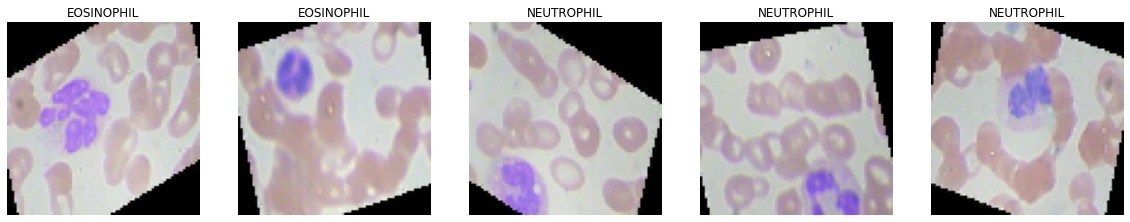

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    etiqueta = train_dataset[rand1][1][rand2]
    if etiqueta[0] == 1:
        ax[i].set_title('EOSINOPHIL')
    elif etiqueta[1] == 1:
        ax[i].set_title('LYMPHOCITE')
    elif etiqueta[2] == 1:
        ax[i].set_title('MONOCYTE')
    elif etiqueta[3] == 1:
        ax[i].set_title('NEUTROPHIL')

# Modelo

**DenseNet169**

Es una red neuronal pre-entrenada perteneciente al grupo de modelos DenseNet diseñado para realizar la clasificación de imágenes. 
Todos fueron entrenados con la base de datos de imágenes de ImageNet

DenseNet es una arquitectura de red en la que cada capa está conectada directamente a todas las demás capas en forma de avance (dentro de cada bloque denso ). Para cada capa, los mapas de características de todas las capas anteriores se tratan como entradas independientes, mientras que sus propios mapas de características se transmiten como entradas a todas las capas posteriores




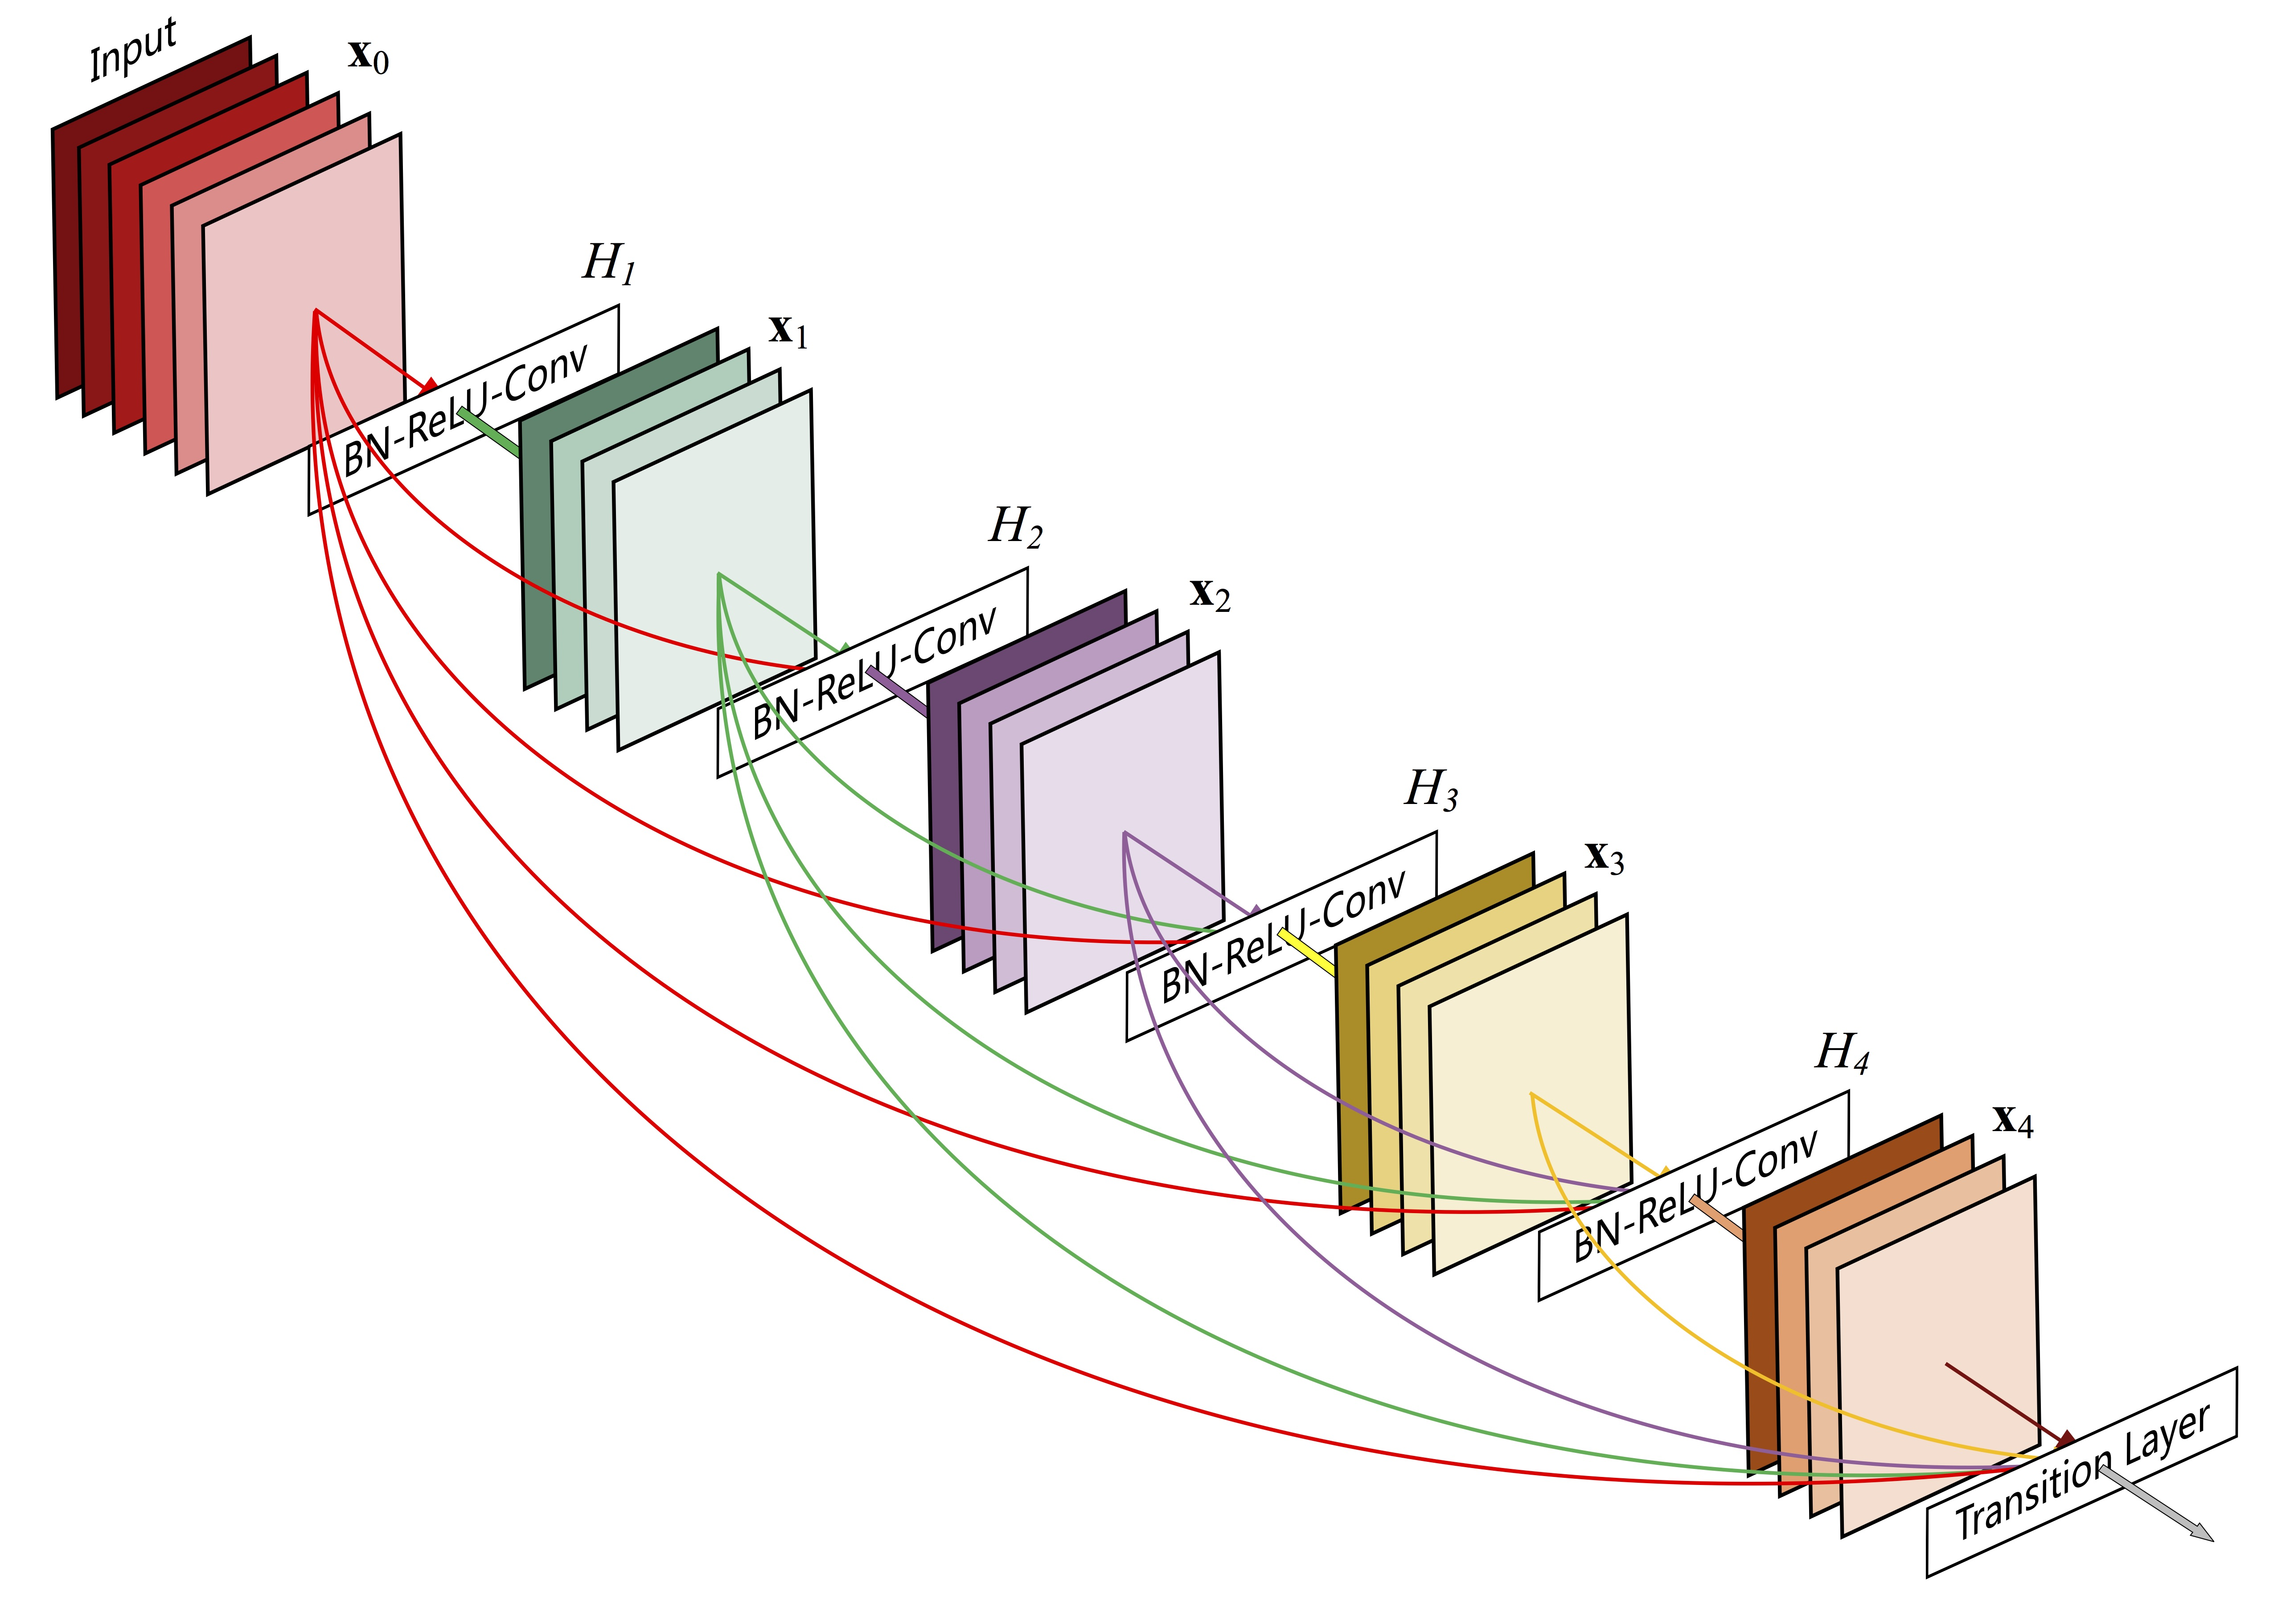

DenseNet tiene varias ventajas convincentes: 

* Previenen el problema de la desaparicion del gradiente
* Fortalecen la propagación de características
* Fomentan la reutilización de funciones 
* Reducen sustancialmente el número de parámetros

https://www.kaggle.com/pytorch/densenet169

https://github.com/liuzhuang13/DenseNet

https://docs.openvinotoolkit.org/latest/omz_models_model_densenet_169.html

In [ ]:
tensorflow.random.set_seed(42)
base_model = DenseNet169(input_shape=(240,320,3), #tamaño de las imagenes
                         include_top=False, #si incluir la capa completamente conectada en la parte superior de la red.
                         weights="imagenet" #voy a usar los pesos que se utilizaron para el entrenamiento con imagenet
                         )

51879936/51877672 [==============================] - 1s 0us/step


In [ ]:
tensorflow.random.set_seed(42)
for layer in base_model.layers:
    layer.trainable=False #Voy a dejar las capas tal como estan

In [ ]:
# Building Model
tensorflow.random.set_seed(42)

model=Sequential() #Instancia de red neuronal

model.add(base_model) #La primera capa es el dense net 169

########################################################################

model.add(Dropout(0.5)) #Los elementos de entrada se establecen aleatoriamente en cero (y los otros elementos se reescalan). 
                        #Esto causa que cada nodo se comporte de forma independiente, ya que no puede depender de la salida de otros nodos.

model.add(Flatten()) #Convierte la matriz de 2D a 1D

model.add(BatchNormalization()) #Normalizacion por lotes: transforma las salidas de las capas en promedio 0 y desviacion 1 para que acelerar el desarrollo

model.add(Dense(2048,kernel_initializer='he_uniform')) #Capa de neuronas para el aprendizaje y que inician con valores extraidos de una distribucion uniforme 

model.add(BatchNormalization()) 

model.add(Activation('relu')) #Modifica los valores de la salida anterior de la siguiente forma: f(x) = max(0,x)

########################################################################

model.add(Dropout(0.5))

model.add(Dense(1024,kernel_initializer='he_uniform'))

model.add(BatchNormalization())

model.add(Activation('relu'))

model.add(Dropout(0.5))

########################################################################

model.add(Dense(4,activation='softmax')) #salida de 4 probabilidades, porque son 4 clases y todas entre 0 y 1

#Compilacion

OPT = tensorflow.keras.optimizers.Adam(lr=0.001) #es un método de descenso de gradiente estocástico que calcula las tasas de aprendizaje adaptativo individual 
                                                 #para diferentes parámetros a partir de estimaciones de momentos de primer y segundo orden de los gradientes.

model.compile(loss='categorical_crossentropy', #Funcion de perdida a disminuir
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc'),'accuracy'], #Metricas para ver el desempeño durante el desarrollo
              optimizer=OPT #Optimizador Adam
              )



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 10, 1664)       12642880  
_________________________________________________________________
dropout (Dropout)            (None, 7, 10, 1664)       0         
_________________________________________________________________
flatten (Flatten)            (None, 116480)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 116480)            465920    
_________________________________________________________________
dense (Dense)                (None, 2048)              238553088 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

https://medium.com/@jaynilbvb/implementing-batch-normalization-in-tensorflow-db3784f61693#:~:text=The%20Batch%20Normalization%20technique%20consists,of%20a%20deep%20neural%20network.

In [ ]:
#Monitoreo
tensorflow.random.set_seed(42)
filepath = './mejores_pesos.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
tensorflow.random.set_seed(42)
historial = model.fit(train_dataset, validation_data=valid_dataset, epochs = 5, callbacks = callback_list, verbose = 1)

Epoch 1/5
250/250 [==============================] - 3740s 15s/step - loss: 1.3216 - auc: 0.7880 - accuracy: 0.5543 - val_loss: 0.4378 - val_auc: 0.9684 - val_accuracy: 0.8363

Epoch 00001: val_accuracy improved from -inf to 0.83626, saving model to ./mejores_pesos.hdf5
Epoch 2/5
250/250 [==============================] - 164s 653ms/step - loss: 0.5169 - auc: 0.9561 - accuracy: 0.8018 - val_loss: 0.1974 - val_auc: 0.9928 - val_accuracy: 0.9247

Epoch 00002: val_accuracy improved from 0.83626 to 0.92466, saving model to ./mejores_pesos.hdf5
Epoch 3/5
250/250 [==============================] - 158s 630ms/step - loss: 0.3738 - auc: 0.9751 - accuracy: 0.8567 - val_loss: 0.1423 - val_auc: 0.9962 - val_accuracy: 0.9442

Epoch 00003: val_accuracy improved from 0.92466 to 0.94425, saving model to ./mejores_pesos.hdf5
Epoch 4/5
250/250 [==============================] - 155s 621ms/step - loss: 0.2894 - auc: 0.9844 - accuracy: 0.8932 - val_loss: 0.1103 - val_auc: 0.9975 - val_accuracy: 0.9583

E

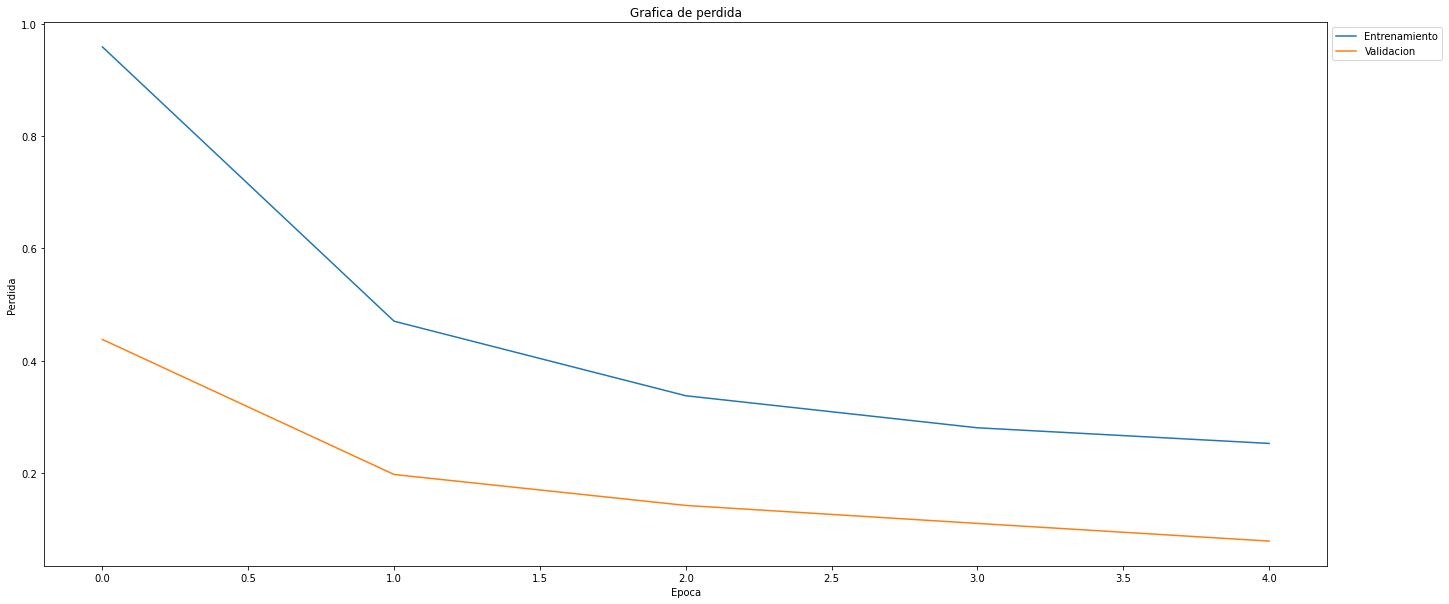

In [ ]:
plt.figure(figsize=(23,10))
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Grafica de perdida')
plt.ylabel('Perdida')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

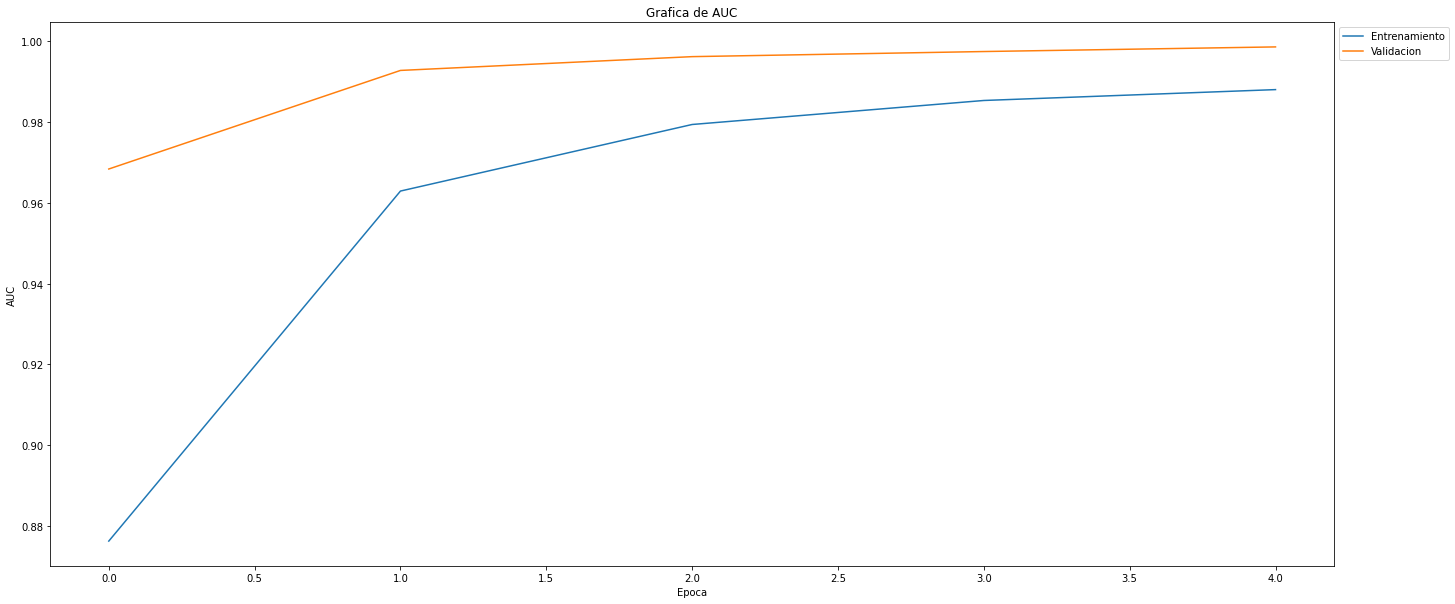

In [ ]:
plt.figure(figsize=(23,10))
plt.plot(historial.history['auc'])
plt.plot(historial.history['val_auc'])
plt.title('Grafica de AUC')
plt.ylabel('AUC')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()